In [1]:
!sudo apt install xvfb
!pip install gymnasium[atari,accept-rom-license]
!pip install stable-baselines3
!pip install PyVirtualDisplay
import torch as th
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import time

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 30 not upgraded.
Need to get 7,816 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [2]:
def q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
  # Доступ к Q-network
  q_net = model.q_net

  # Конвертируем observation в PyTorch tensor
  obs_tensor = th.tensor(obs, dtype=th.float32)

  # Изменяем размерность
  obs_tensor = obs_tensor.unsqueeze(0)

  #Извлекаем Q-values
  q_values = model.q_net.forward(obs_tensor.cuda())

  return q_values.cpu().detach().numpy()[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def plot_q_values(q_values_list):

  # Построение графика
  plt.figure(figsize=(10, 6))
  for i in range(6):
    plt.plot(q_values_list[i], label='Q%i Values' % i)
  plt.xlabel('Time')
  plt.ylabel('Q-Values')
  plt.title('Convergence of Q-Values over Time')
  plt.legend()
  plt.show()

In [4]:
def mean_reward(discount_factor):
  #Создание окружения
  env = gym.make("Taxi-v3")

  #Создание модели
  model = DQN("MlpPolicy", env, verbose=1, gamma=discount_factor, learning_rate=0.001)

  #Количество эпизодов для оценки модели
  n_eval_episodes = 250

  #Оценка модели до обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("Taxi-v3", render_mode="rgb_array"), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"До обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

  # Засекаем начальное время
  start_time = time.time()

  #Обучение модели
  model.learn(total_timesteps=10000, log_interval=100)

  # Засекаем время завершения
  end_time = time.time()

  #Оценка модели после обучения
  mean_reward, std_reward = evaluate_policy(model, gym.make("Taxi-v3", render_mode="rgb_array"), deterministic=True, n_eval_episodes=n_eval_episodes)
  print(f"После обучения модели с discount_factor = {discount_factor}, mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
  model.save(f"dqn_taxi_{discount_factor}")
  del model

  # Вычисляем время обучений
  learn_time = end_time - start_time
  return env, learn_time

In [5]:
def q_values_calculation(discount_factor, env):
  #Загружаем созданную и созраненную модель
  model = DQN.load(f"dqn_taxi_{discount_factor}")

  action_str = ['down', 'up', 'right', 'left', "pick up", "drop off"]
  q_values_list = []

  obs, info = env.reset()
  for _ in range(100):
      q_val = q_values(model,obs)
      q_values_list.append(q_val)
      action, _states = model.predict(obs, deterministic=True)

      print(f"Q-value состояния down={q_val[0]:.2f} up={q_val[1]:.2f} right={q_val[2]:.2f} left={q_val[3]:.2f} pick up={q_val[4]:.2f} drop off={q_val[5]:.2f}")
      print(f"Действие: {action_str[action]}")

      obs, reward, terminated, truncated, _ = env.step(int(action))

  return q_values_list

In [6]:
discount_factors = [0.001, 0.01, 0.1, 0.5, 0,75, 0.99]

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


До обучения модели с discount_factor = 0.001, mean_reward:-1999.64 +/- 1.76
После обучения модели с discount_factor = 0.001, mean_reward:-1999.75 +/- 1.48
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действие: pick up
Q-value состояния down=-0.12 up=-0.11 right=-0.10 left=-0.08 pick up=0.06 drop off=-0.04
Действи

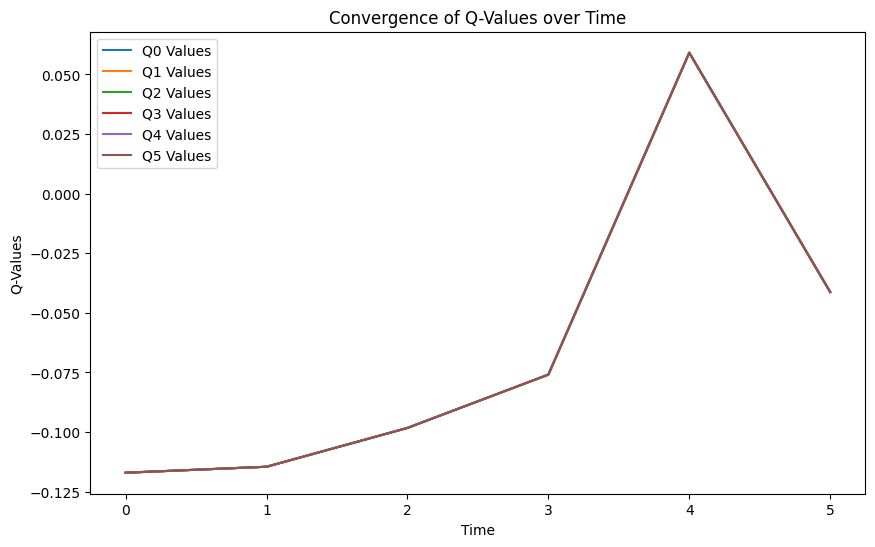

Время обучения модели при discount_factor = 0.001 : 1.0542089939117432 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.01, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 0.01, mean_reward:-200.00 +/- 0.00
Q-value состояния down=0.04 up=0.04 right=-0.06 left=0.09 pick up=-0.09 drop off=0.04
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.08 drop off=0.03
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.08 drop off=0.03
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.08 drop off=0.03
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.08 drop off=0.03
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.08 drop off=0.03
Действие: left
Q-value состояния down=0.05 up=0.03 right=-0.05 left=0.10 pick up=-0.

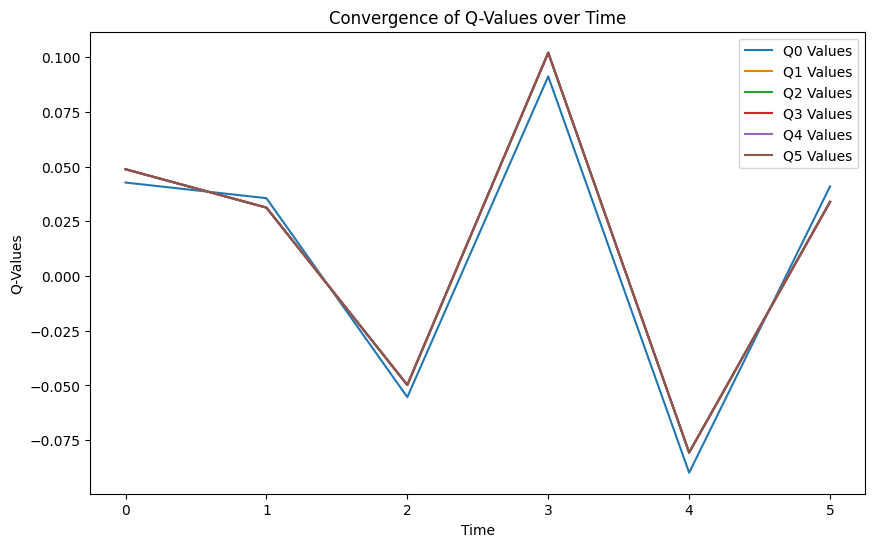

Время обучения модели при discount_factor = 0.01 : 1.023371696472168 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.1, mean_reward:-2000.00 +/- 0.00
После обучения модели с discount_factor = 0.1, mean_reward:-2000.00 +/- 0.00
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 up=-0.03 right=-0.00 left=-0.12 pick up=-0.09 drop off=0.10
Действие: drop off
Q-value состояния down=-0.13 

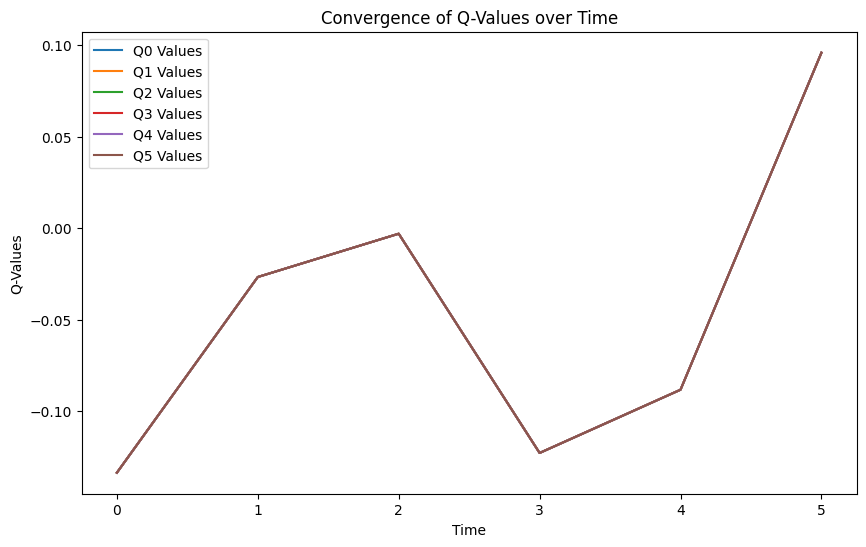

Время обучения модели при discount_factor = 0.1 : 0.9820685386657715 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.5, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 0.5, mean_reward:-200.00 +/- 0.00
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-0.07 drop off=-0.00
Действие: down
Q-value состояния down=0.10 up=-0.07 right=0.07 left=0.04 pick up=-

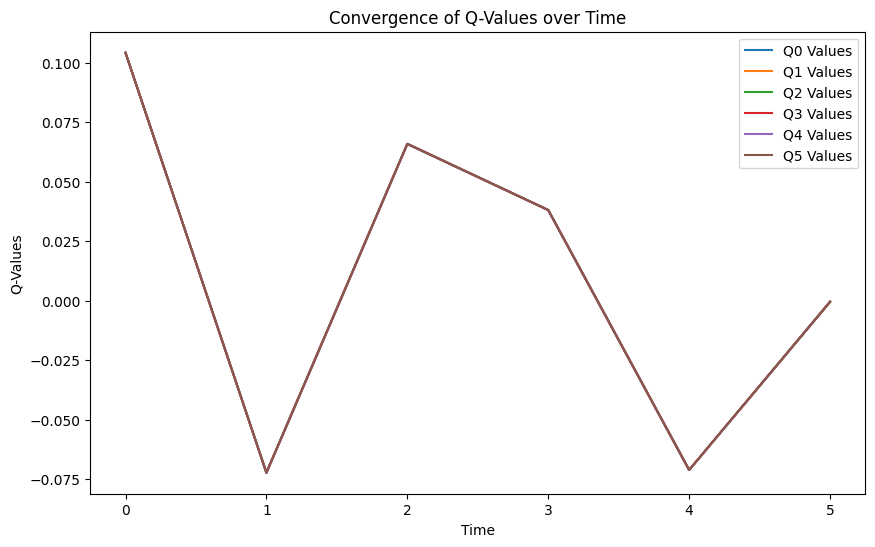

Время обучения модели при discount_factor = 0.5 : 0.9501233100891113 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0, mean_reward:-529.65 +/- 694.22
После обучения модели с discount_factor = 0, mean_reward:-629.41 +/- 764.16
Q-value состояния down=0.02 up=-0.08 right=-0.04 left=-0.05 pick up=-0.00 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.08 right=-0.04 left=-0.05 pick up=-0.01 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.07 right=-0.04 left=-0.05 pick up=-0.01 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.07 right=-0.04 left=-0.05 pick up=-0.01 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.07 right=-0.04 left=-0.05 pick up=-0.01 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.07 right=-0.04 left=-0.05 pick up=-0.01 drop off=0.00
Действие: down
Q-value состояния down=0.01 up=-0.07 right=-0.04 left=-0.05 p

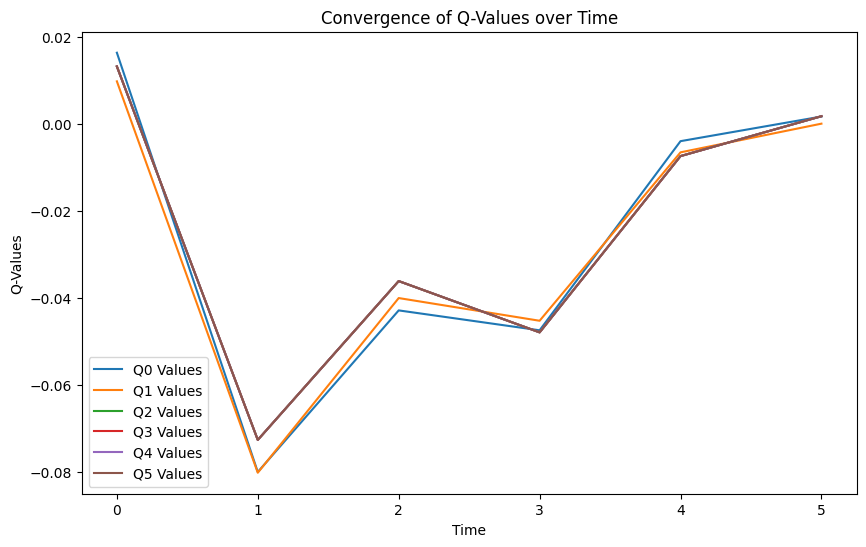

Время обучения модели при discount_factor = 0 : 0.9804847240447998 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 75, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 75, mean_reward:-200.00 +/- 0.00
Q-value состояния down=-0.04 up=0.01 right=-0.02 left=0.11 pick up=0.04 drop off=-0.03
Действие: left
Q-value состояния down=-0.04 up=0.00 right=-0.03 left=0.11 pick up=0.04 drop off=-0.02
Действие: left
Q-value состояния down=-0.04 up=0.01 right=-0.02 left=0.10 pick up=0.04 drop off=-0.02
Действие: left
Q-value состояния down=-0.05 up=0.00 right=-0.02 left=0.11 pick up=0.05 drop off=-0.03
Действие: left
Q-value состояния down=-0.05 up=0.01 right=-0.02 left=0.10 pick up=0.04 drop off=-0.03
Действие: left
Q-value состояния down=-0.05 up=0.01 right=-0.02 left=0.10 pick up=0.04 drop off=-0.03
Действие: left
Q-value состояния down=-0.05 up=0.01 right=-0.02 left=0.10 pick up=0.04

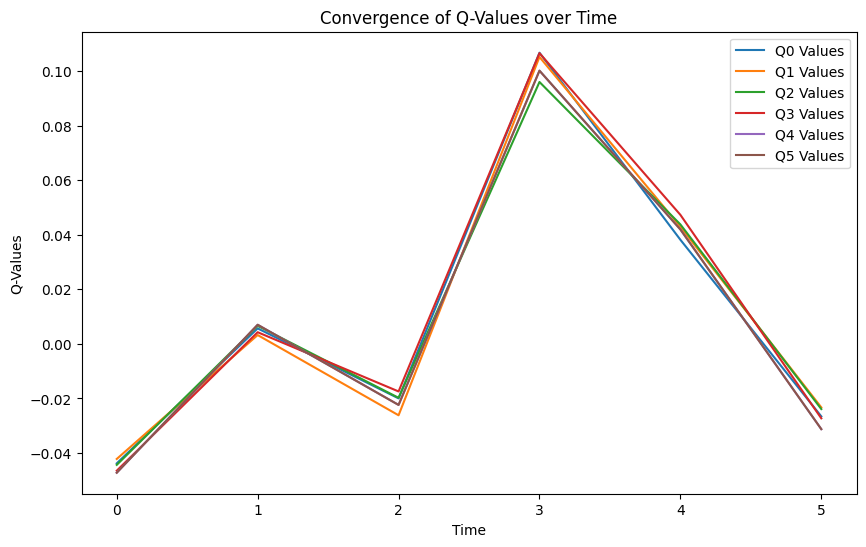

Время обучения модели при discount_factor = 75 : 1.0028917789459229 секунд.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
До обучения модели с discount_factor = 0.99, mean_reward:-200.00 +/- 0.00
После обучения модели с discount_factor = 0.99, mean_reward:-200.00 +/- 0.00
Q-value состояния down=0.10 up=-0.01 right=-0.11 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.10 up=-0.02 right=-0.10 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.11 up=-0.03 right=-0.10 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.11 up=-0.03 right=-0.10 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.11 up=-0.03 right=-0.10 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.11 up=-0.03 right=-0.10 left=0.01 pick up=0.05 drop off=-0.01
Действие: down
Q-value состояния down=0.11 up=-0.03 right=-0.10 left=0.01 pick up

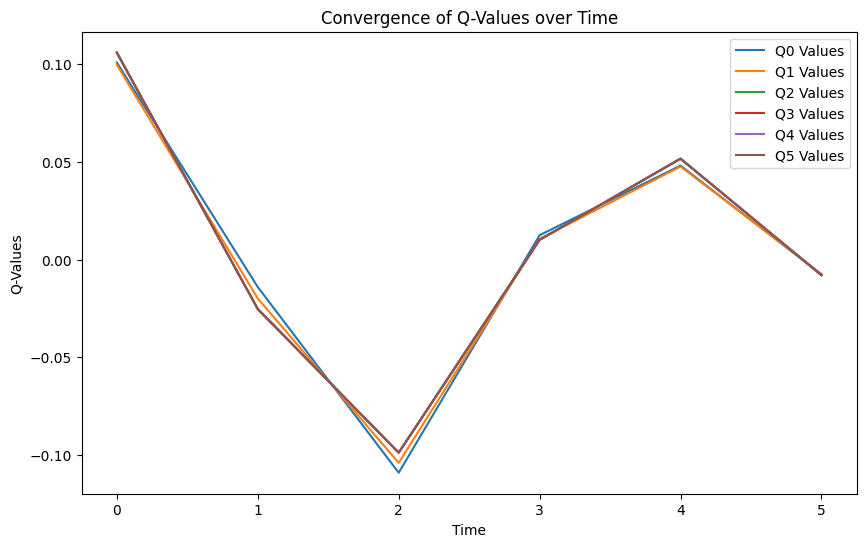

Время обучения модели при discount_factor = 0.99 : 0.9566242694854736 секунд.


In [7]:
for discount_factor in discount_factors:
  environment, time_to_lrn = mean_reward(discount_factor)
  q_vals = q_values_calculation(discount_factor, environment)
  plot_q_values(q_vals)
  print(f'Время обучения модели при discount_factor = {discount_factor} : {time_to_lrn} секунд.')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
